# Monte-Carlo Method For Calculating Option Prices

In [1]:
import MonteCarlo as mc 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from scipy.stats import norm 
from scipy import stats

## Initialize an Option

In [2]:
#note strike date is calc to per annum
option = mc.Option(K=10,T=0.25,S_0=10,r=0.02,sigma=0.25,putOrCall='call')
dt=0.025 #per annum
print(option)
print(f"Over time steps: {dt}")

Call Option: Strike=$10.00, Spot=$10.00, Expiry=0.25y, Rate=2.00%, Vol=25.00%
Over time steps: 0.025


## Compare Black-Scholes-Merton Method VS Monte-Carlo

In [3]:
black_scholes_merton_price = round(option.calc_black_scholes_merton(),4)
results = {}
time_steps = [10,100,1000,10000]
for val in time_steps:
    simulated_path = mc.simulate(num_simulations=val, option=option, dt=dt)
    expected_price = mc.calc_expected_price(simulated_paths=simulated_path, option=option)
    results[val] = expected_price

In [4]:
df = pd.DataFrame({
    'Type': [f'N={n}' for n in results.keys()],
    'Monte Carlo Solution': list(results.values()),
    'black_scholes_merton_price': black_scholes_merton_price, 
    '|E|': [abs(results[n] - black_scholes_merton_price) for n in results.keys()]
})

print(df.to_string(index=False))

   Type  Monte Carlo Solution  black_scholes_merton_price      |E|
   N=10              0.403291                      0.5224 0.119109
  N=100              0.506807                      0.5224 0.015593
 N=1000              0.492171                      0.5224 0.030229
N=10000              0.532262                      0.5224 0.009862


## Visualizing Results

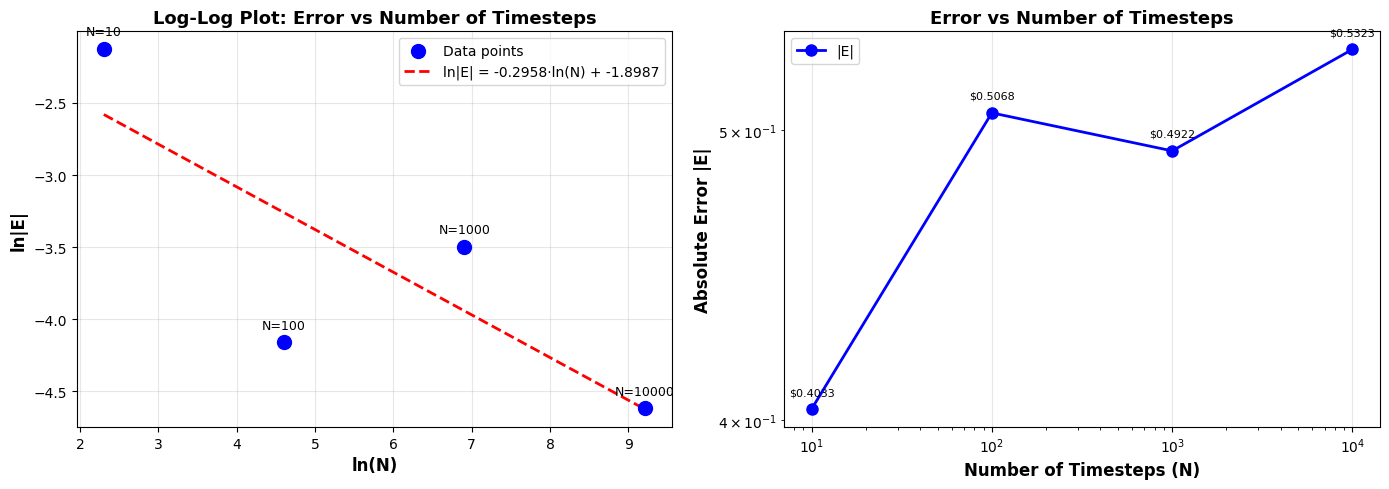

In [5]:
ln_N = np.log(time_steps)
ln_E = np.log([abs(results[n] - black_scholes_merton_price) for n in time_steps])

#fit a lin. regression line 
slope, intercept, r_value, p_value, std_err = stats.linregress(ln_N, ln_E)
convergence_rate = -slope

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(ln_N, ln_E, s=100, color='blue', label='Data points', zorder=3)
ax1.plot(ln_N, slope * ln_N + intercept, 'r--', linewidth=2, 
         label=f'ln|E| = {slope:.4f}·ln(N) + {intercept:.4f}', zorder=2)
ax1.set_xlabel('ln(N)', fontsize=12, fontweight='bold')
ax1.set_ylabel('ln|E|', fontsize=12, fontweight='bold')
ax1.set_title('Log-Log Plot: Error vs Number of Timesteps', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# data labels
for i, (x, y) in enumerate(zip(ln_N, ln_E)):
    ax1.annotate(f'N={time_steps[i]}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

# error vs N on regular scale
ax2.plot(time_steps, [results[N] for N in time_steps], 'bo-', linewidth=2, 
         markersize=8, label='|E|')
ax2.set_xlabel('Number of Timesteps (N)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Absolute Error |E|', fontsize=12, fontweight='bold')
ax2.set_title('Error vs Number of Timesteps', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(fontsize=10)

for N in time_steps:
    ax2.annotate(f'${results[N]:.4f}', (N, results[N]), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

## Heston Model

In [ ]:
omega, theta, xi, nu_0 = 0.0625, 3, 0.1, 0.0625
heston_model_results = {}
for val in time_steps:
    simulated_path = mc.simulate(num_simulations=val, option=option, dt=dt, theta=theta, omega=omega, xi=xi, nu_0=nu_0)
    expected_price = mc.calc_expected_price(simulated_paths=simulated_path, option=option)
    heston_model_results[val] = expected_price
    


## Heston Model Results

In [11]:
df_heston = pd.DataFrame({
    'Type': [f'N={n}' for n in heston_model_results.keys()],
    'Heston Model Solution': list(heston_model_results.values())
})

print(df_heston.to_string(index=False))

   Type  Heston Model Solution
   N=10               0.658384
  N=100               0.487990
 N=1000               0.509763
N=10000               0.525493


## Why No Heston Vs. Black-Scholes-Merton? 

In the final steps of this analysis, we are posed with the question of whether or not it is fair to compared BSM solution to the Heston models solution. It is not fair to compare the two results. BSM is derived under the assumption that volatility is constant for the underlying asset following an Ito Process. The Heston model assumes the opposite. It captures volatility as a stochastic process over periods of time. Therefore, we should not compare the results of both processes. 